## 상수 설정

In [ ]:
FILE_NAME = "breastfeeding_month.CSV"
FILE_PATH = f"topic-modeling-of-mom-community/data/{FILE_NAME}"
FILTER_COL = "group"
TARGET_COL = "title"
GROUP = 5
PROCESSED_COL = "ProcessedData"
HANSPELL_MAX_LENGTH = 500
KONLPY_MAX_LENGTH = 3000

## 패키지 설치 및 불러오기

### 전처리 과정에서 필요한 패키지 설치 및 불러오기

In [ ]:
import sys
sys.executable

In [ ]:
# !pip install py-hanspell

!git clone https://github.com/ssut/py-hanspell.git
!cd /usr/local/lib/python3.8/dist-packages/ && mkdir hanspell
!cd py-hanspell && cp -r hanspell/ /usr/local/lib/python3.8/dist-packages/

fatal: destination path 'py-hanspell' already exists and is not an empty directory.
mkdir: cannot create directory ‘hanspell’: File exists


In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached konlpy-0.6.0-py2.py3-none-any.whl (19.4 MB)


In [ ]:
import site
import os
import pandas as pd
import re
from tqdm import tqdm
from hanspell import spell_checker
from konlpy.tag import Hannanum

### 토픽 모델링 과정에서 필요한 패키지 설치 및 불러오기

In [ ]:
!pip install -upgrade setuptools


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=48836e2115405e8a902e321d01a6f31273a88ef75e3cda62299bb959acfbc5ac
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=b1a966f259ca2ff3a85393d4d1febbf81f6e7ae6dbaa4653eeaffba524333106
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from gensim import corpora
import numpy as np
import nltk
nltk.download('punkt')
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.gensim_models 
import gensim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [ ]:
!git clone https://github.com/oneonlee/topic-modeling-of-mom-community.git

Cloning into 'topic-modeling-of-mom-community'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 32 (delta 6), reused 31 (delta 5), pack-reused 0
Unpacking objects: 100% (32/32), done.


## 데이터 및 사전 불러오기 및 사전 중복 검사

In [ ]:
def duplicate_check(df, dictionary_name):

    src = list(df)[0]
    dest = list(df)[1]
    
    dup = df.duplicated([src])
    df_dup = pd.concat([df, dup], axis=1)
    df_dup.rename(columns={0: 'Dup'}, inplace=True)
    df_dup['Dup'].value_counts()

    if df_dup['Dup'].values.sum() > 0:
        print(f"{dictionary_name}에서 중복 key 값이 발견되었습니다!")
        for i in range(len(df_dup)):
            if df_dup['Dup'][i]:
                # print(f"중복되는 key 값 : {df_dup['#en'][i]} (index at {i})")
                print(f"중복되는 key 값 : {df_dup[src][i]} (index at {i})")

    else:
        print(f"{dictionary_name}에서 중복되는 값이 없습니다.")
    
    print("사전에서 읽어들인 용어의 개수 :", len(df), "\n")

In [ ]:
user_dic_df = pd.read_csv("topic-modeling-of-mom-community/data/dictionary/synonym.csv", encoding="utf-8", low_memory=False)
stopwords_df = pd.read_csv("topic-modeling-of-mom-community/data/dictionary/stopwords.csv", encoding="utf-8", low_memory=False)
fix_df = pd.read_csv("topic-modeling-of-mom-community/data/dictionary/spell_fix.csv", encoding="utf-8", low_memory=False)

duplicate_check(user_dic_df, "synonym")
duplicate_check(stopwords_df, "stopwords_df")
duplicate_check(fix_df, "fix_df")

synonym에서 중복 key 값이 발견되었습니다!
중복되는 key 값 : 해주세요 (index at 1741)
중복되는 key 값 : 안늘어나 (index at 1770)
중복되는 key 값 : 관계요 (index at 3269)
사전에서 읽어들인 용어의 개수 : 4512 

stopwords_df에서 중복 key 값이 발견되었습니다!
중복되는 key 값 : 저는 (index at 797)
중복되는 key 값 : 줄일 (index at 870)
중복되는 key 값 : 기타 (index at 1098)
중복되는 key 값 : 아우 (index at 1246)
사전에서 읽어들인 용어의 개수 : 1437 

fix_df에서 중복되는 값이 없습니다.
사전에서 읽어들인 용어의 개수 : 401 



In [ ]:
syn_df = pd.read_csv("topic-modeling-of-mom-community/data/dictionary/synonym.csv", encoding="utf-8", low_memory=False)

for idx in range(len(syn_df['삭제여부'])):
    if syn_df['삭제여부'][idx]==True:
        syn_df['synonym'][idx] = "" 

# synonym 행 중 값이 없는 행은 삭제
syn_df = syn_df[syn_df['synonym'].notna()] 
syn_df = syn_df[['word', 'synonym']] 

# index 재구성
len_syn = len(syn_df['synonym'])
syn_index = [i for i in range(len_syn)]
syn_df = syn_df.set_index(pd.Index(syn_index))  

duplicate_check(syn_df, "syn_df")

<ipython-input-12-8d4643de3e53>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_df['synonym'][idx] = ""


syn_df에서 중복 key 값이 발견되었습니다!
중복되는 key 값 : 해주세요 (index at 1741)
중복되는 key 값 : 안늘어나 (index at 1770)
중복되는 key 값 : 관계요 (index at 3269)
사전에서 읽어들인 용어의 개수 : 4512 



In [ ]:
final_fix_df = pd.read_csv("topic-modeling-of-mom-community/data/dictionary/final_fix.csv", encoding="utf-8", low_memory=False)

final_fix_df = final_fix_df[['problem', 'fix']] 
final_fix_df = final_fix_df[final_fix_df['problem'].notna()] 
final_fix_df = final_fix_df.fillna(' ')

duplicate_check(final_fix_df, "final_fix_df")

final_fix_df에서 중복 key 값이 발견되었습니다!
중복되는 key 값 : 안나오 (index at 20)
중복되는 key 값 : 안준단 (index at 21)
중복되는 key 값 : 불편해 (index at 22)
중복되는 key 값 : 두시간 (index at 23)
중복되는 key 값 : 필요해 (index at 24)
중복되는 key 값 : 안먹어 (index at 25)
중복되는 key 값 : 안나와 (index at 26)
사전에서 읽어들인 용어의 개수 : 49 



In [ ]:
try:
  KONLPY_DIC_PATH = '/konlpy/java/data/kE/dic_user.txt'

  correct_path_cnt = 0 # KONLPY_DIC_PATH를 가지고 있는 경로가 1개 뿐이어야 함

  for sitepackages_path in site.getsitepackages():
    if os.path.isfile(sitepackages_path + KONLPY_DIC_PATH) == True:
      correct_path_cnt += 1
      DATA_PATH = sitepackages_path + KONLPY_DIC_PATH

  if correct_path_cnt > 1: # KONLPY_DIC_PATH를 가지고 있는 경로가 중복될 경우
    raise Exception("konlpy 라이브러리를 포함하는 site-packages의 경로가 여러 개 있습니다.\n!pip show konlpy 명령어 실행 후, \"Location:\"에 있는 경로를 직접 입력해주세요. ")

except:
  DATA_PATH = input("\n`!pip show konlpy` 명령어를 실행하여 확인한 \"Location:\"에 있는 경로를 직접 입력해주세요. : ")

In [ ]:
dic_user_df = pd.read_table('topic-modeling-of-mom-community/data/dictionary/dic_user.txt')
dic_user_df.to_csv(DATA_PATH, index=False, header=False, sep='\t')
duplicate_check(dic_user_df, "dic_user.txt")

hannanum = Hannanum()

dic_user.txt에서 중복 key 값이 발견되었습니다!
중복되는 key 값 : 안운 (index at 1164)
중복되는 key 값 : 점프 (index at 1530)
중복되는 key 값 : 물 (index at 2369)
중복되는 key 값 : 반품 (index at 2377)
중복되는 key 값 : 반점 (index at 2378)
중복되는 key 값 : 반입 (index at 2379)
중복되는 key 값 : 반응 (index at 2380)
중복되는 key 값 : 반사 (index at 2381)
중복되는 key 값 : 반복 (index at 2382)
중복되는 key 값 : 반반 (index at 2383)
중복되는 key 값 : 반모 (index at 2384)
중복되는 key 값 : 반란 (index at 2385)
중복되는 key 값 : 반대 (index at 2386)
중복되는 key 값 : 바보 (index at 2387)
중복되는 key 값 : 바닥 (index at 2388)
중복되는 key 값 : 바늘 (index at 2389)
중복되는 key 값 : 밀봉 (index at 2390)
중복되는 key 값 : 민망 (index at 2391)
중복되는 key 값 : 믹스 (index at 2392)
중복되는 key 값 : 미용 (index at 2393)
중복되는 key 값 : 미열 (index at 2394)
중복되는 key 값 : 미안 (index at 2395)
중복되는 key 값 : 미숙 (index at 2396)
중복되는 key 값 : 미련 (index at 2397)
중복되는 key 값 : 미달 (index at 2398)
중복되는 key 값 : 물총 (index at 2399)
중복되는 key 값 : 물집 (index at 2400)
중복되는 key 값 : 물양 (index at 2401)
중복되는 key 값 : 물건 (index at 2402)
중복되는 key 값 : 문제 (index at 2403)
중복되는 ke

In [ ]:
data = pd.read_csv(FILE_NAME,encoding='cp949')
print(f"{FILE_NAME}에서 {len(data)}개의 data를 불러왔습니다.")

breastfeeding_month.CSV에서 45911개의 data를 불러왔습니다.


In [ ]:
data

,Unnamed: 0,num,date,title,개월 수 추측어려움,group,month,text,Unnamed: 8
0,0,1,2019.10.22. 17:52,비지엔젤 젖병이랑 유피스 신제품 젖꼭지,물품(젖병문의),5,NaN,호환해서 쓰는 분 있나요?더블하트에 호환해서 쓰는데비싸고 일본꺼라서요유피스 신제품 ...,NaN
1,1,2,2019.10.22. 17:51,뉴위드맘 무항생제위드맘,물품(분유문의),5,NaN,두개 차이 아시는 분..? 지금 무항생제 위드맘 1단계 먹이는 중인데갑자기 2일 1...,NaN
2,2,3,2019.10.22. 17:50,안녕하세요 잘 안먹는아이 분유추천좀요,NaN,3,5개월,5개월에 막 들어섰어요50일째때까지만 해도 엄청 잘먹었는데이후 70일 백일.. 먹는...,NaN
3,3,4,2019.10.22. 17:49,수유양좀 알려주세요~~,NaN,2,1개월,57일아가이고 5.4kg 혼합이예요 최대한 낮에 직수하려하는데 새벽에는 많이 빠는데...,NaN
4,4,5,2019.10.22. 17:49,"살 ""안""찌는 분유 좀 추천 해 주세요.",NaN,2,2개월,제목 그대로 살찌는 분유 말구요 살 '안'찌는 분유 좀 추천 해 주세요. 오늘 예방...,NaN
...,...,...,...,...,...,...,...,...,...
45906,45906,45907,2019.05.07. 21:27,무항생제 위드맘 백일 먹는데 계속 똥테러 중이네요...,NaN,3,3개월,"제목 그대로에요.병원에서는 남양 먹고, 조리원에서 중간에 무항생제 위드맘 백일 먹여...",NaN
45907,45907,45908,2019.05.07. 21:16,초유 3시간 유축했는데 이만큼 나왔어요ㅠㅠ,NaN,1,0개월,이거라도 갖다 줘야겠죠?ㅠㅠㅠㅠㅠ초유는 원래 이렇게 조금 나오나요?ㅠㅠ,NaN
45908,45908,45909,2019.05.07. 21:11,남양 ㅇㅏ이엠마더 먹이는분계시나용 ㅠㅠ?,NaN,3,3개월,워낙 말이많아서 고민하다가조리원에서 아이엠마더 먹여서 일단먹였는데배앓이나 게워내고 ...,NaN
45909,45909,45910,2019.05.07. 21:02,하...아기가 잘 안자고 금방 다음 수유시간 와버리네요ㅋㅋㅋ,NaN,1,0개월,생후 20일 초반 아기에요 모유수유에 분유보충하는 방법 위주로 밥 주고있어요 와 오...,NaN


In [ ]:
group = data[FILTER_COL] == GROUP
group_data = data[group]
group_data

,Unnamed: 0,num,date,title,개월 수 추측어려움,group,month,text,Unnamed: 8
0,0,1,2019.10.22. 17:52,비지엔젤 젖병이랑 유피스 신제품 젖꼭지,물품(젖병문의),5,NaN,호환해서 쓰는 분 있나요?더블하트에 호환해서 쓰는데비싸고 일본꺼라서요유피스 신제품 ...,NaN
1,1,2,2019.10.22. 17:51,뉴위드맘 무항생제위드맘,물품(분유문의),5,NaN,두개 차이 아시는 분..? 지금 무항생제 위드맘 1단계 먹이는 중인데갑자기 2일 1...,NaN
5,5,6,2019.10.22. 17:48,모유수유 중 독감주사 맞아도 되나요?,예방접종(독감주사문의),5,NaN,주사는 괜찮죠?,NaN
6,6,7,2019.10.22. 17:45,유축,유축시간간격,5,NaN,보통 유축 몇시간애 한번씩 하시나요 ? 완모하신 어머님들 궁금해용,NaN
8,8,9,2019.10.22. 17:38,혼합수유에서 분유수유만 하려면 어떻게 해야하나요?,분유수유방법,5,NaN,혼합으로 해서 소화 안될까봐 하루에 4번정도 분유보충해요. 집 체중계로 재봤을때(애...,NaN
...,...,...,...,...,...,...,...,...,...
45890,45890,45891,2019.05.07. 22:02,마더세이프와 의사가 말이 다른데..,NaN,5,NaN,항생제를 먹게됐는데의사는 약을 끊고 일주일 뒤부터 수유하라고 하고마더세이프에서는 약...,NaN
45893,45893,45894,2019.05.07. 21:58,가슴이 땅땅하고 너무 아픈데 어떻게 해야할까요??,NaN,5,NaN,가슴이 땅땅한데 어떻게 해야할까요?? 전체가 그런게 아니고 오른쪽 위쪽만 엄청 땡땡...,NaN
45902,45902,45903,2019.05.07. 21:34,직수후 유축해야할까요????,NaN,5,NaN,황달끼가 없어져서 오늘부터 모유직수 30분정도햇는데..20분할때도 잇고그후에 유축을...,NaN
45903,45903,45904,2019.05.07. 21:33,여기저기서 샘플?사은품?으로 받은 젖병은 어떻게 쓰세요?,NaN,5,NaN,일단 스펙트라 젖병 + 모유실감 젖꼭지를 사두긴 했는데베페나 병원에서 받은 pp재질...,NaN


### 데이터의 결측값 여부 확인

In [ ]:
print(f"총 데이터(row)의 수 : {len(group_data)}")

print(f"\n===== {TARGET_COL} column의 결측값 여부 확인 =====")
print('결측값 여부 :', group_data[TARGET_COL].isnull().values.any())
print(f"원본 데이터의 유니크한 값 : {group_data[TARGET_COL].nunique()}")

print(f"\n===== {FILTER_COL} column의 결측값 여부 확인 =====")
print('결측값 여부 :', group_data[FILTER_COL].isnull().values.any())
print(f"원본 데이터의 유니크한 값 : {group_data[FILTER_COL].nunique()}")

총 데이터(row)의 수 : 14444

===== title column의 결측값 여부 확인 =====
결측값 여부 : False
원본 데이터의 유니크한 값 : 13971

===== group column의 결측값 여부 확인 =====
결측값 여부 : False
원본 데이터의 유니크한 값 : 1


## 토픽 모델링을 위한 전처리 작업

In [ ]:
group_data[PROCESSED_COL] = [False for _ in range(len(group_data[TARGET_COL]))]

<ipython-input-24-544e5f24a442>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data[PROCESSED_COL] = [False for _ in range(len(group_data[TARGET_COL]))]


### 개행 문자 (`CRLF`) 제거

In [ ]:
def remove_CRLF(input_str):
    input_str = input_str.replace("\n", " ")
    input_str = input_str.replace("\\n", " ")
    input_str = input_str.replace("\r", " ")
    input_str = input_str.replace("\\r", " ")

    return input_str

In [ ]:
for i in group_data['Unnamed: 0']:
    group_data[PROCESSED_COL][i] = remove_CRLF(group_data[TARGET_COL][i])

<ipython-input-26-49787f2853db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data[PROCESSED_COL][i] = remove_CRLF(group_data[TARGET_COL][i])
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_need

### 이모티콘 문자들, 사이트 URL 주소, 의미없는 문자 지우기

In [ ]:
def cleansing(input_str):
    output_str = re.sub(pattern='<[U]\+[A-Z0-9]*>', repl=' ', string=input_str)
    output_str = re.sub(pattern='http[s]?://(?:[a-zA-Z]|[0-9]|[_$\-@\.&+:/?=]|[!*\(\),]|(?:%[0-9a-fA-F_][0-9a-fA-F_]))+', repl=' ', string=output_str)
    output_str = re.sub(pattern='^[0-9]+$', repl=' ', string=output_str)

    return output_str

<>:2: DeprecationWarning: invalid escape sequence \+
<>:3: DeprecationWarning: invalid escape sequence \-
<>:2: DeprecationWarning: invalid escape sequence \+
<>:3: DeprecationWarning: invalid escape sequence \-
<ipython-input-27-979b4ebbfe80>:2: DeprecationWarning: invalid escape sequence \+
  output_str = re.sub(pattern='<[U]\+[A-Z0-9]*>', repl=' ', string=input_str)
<ipython-input-27-979b4ebbfe80>:3: DeprecationWarning: invalid escape sequence \-
  output_str = re.sub(pattern='http[s]?://(?:[a-zA-Z]|[0-9]|[_$\-@\.&+:/?=]|[!*\(\),]|(?:%[0-9a-fA-F_][0-9a-fA-F_]))+', repl=' ', string=output_str)


In [ ]:
for i in group_data['Unnamed: 0']:    
    group_data[PROCESSED_COL][i] = cleansing(group_data[PROCESSED_COL][i])

### 맞춤법 및 띄어쓰기 교정

In [ ]:
def spell_check(input_str):
    output_str = input_str.replace("&", " ")

    try:
        tmp = spell_checker.check(output_str).checked # 500자가 넘는 경우 빈 문자열로 반환됨
        if tmp!="": 
            output_str = tmp
    except:
        print("hanspell : spell_checker error\n")
    
    return output_str

In [ ]:
print("Spell checking start")

for i in tqdm(group_data['Unnamed: 0']):
    group_data[PROCESSED_COL][i] = spell_check(group_data[PROCESSED_COL][i])

Spell checking start


 47%|████▋     | 6797/14444 [17:58<22:51,  5.57it/s]

hanspell : spell_checker error



100%|██████████| 14444/14444 [38:01<00:00,  6.33it/s]


#### 교정 오류 수정

In [ ]:
def spell_fix(spell_checked_str):
    for i in range(len(fix_df["fix"])):
        spell_checked_str = spell_checked_str.replace(fix_df["problem"][i], fix_df["fix"][i])

    return spell_checked_str

In [ ]:
for i in tqdm(group_data['Unnamed: 0']):
    group_data[PROCESSED_COL][i] = spell_fix(group_data[PROCESSED_COL][i])

100%|██████████| 14444/14444 [01:06<00:00, 217.16it/s]


### 데이터의 앞뒤에 공백 추가

In [ ]:
def add_space(input_str):
    return " "+input_str+" "

In [ ]:
for i in group_data['Unnamed: 0']:
    group_data[PROCESSED_COL][i] = add_space(group_data[PROCESSED_COL][i])

### 토큰화 전 불용어(stopwords) 제거

In [ ]:
def remove_stopwords(input_str):
    input_str = re.sub(pattern='([0-9ㄱ-ㅎㅏ-ㅣ]+)', repl='', string=input_str)
    for i in range(len(stopwords_df["nursing"].dropna())):
        input_str = input_str.replace(" "+stopwords_df["nursing"][i]+" ", " ")
    for i in range(len(stopwords_df["korean"].dropna())):
        input_str = input_str.replace(" "+stopwords_df["korean"][i]+" ", " ")
    for i in range(len(stopwords_df["internet"].dropna())):
        input_str = input_str.replace(stopwords_df["internet"][i], " ")
    output_str = re.sub("\s+", " ", input_str)

    return output_str

<>:9: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \s
<ipython-input-35-aff2050e5d55>:9: DeprecationWarning: invalid escape sequence \s
  output_str = re.sub("\s+", " ", input_str)


In [ ]:
for i in tqdm(group_data['Unnamed: 0']):
    group_data[PROCESSED_COL][i] = remove_stopwords(group_data[PROCESSED_COL][i])

100%|██████████| 14444/14444 [03:18<00:00, 72.62it/s]


### 토큰화

In [ ]:
def tokenization(input_str):
    if input_str.strip() == "": # 문장이 비어있는 경우
        return " "

    elif len(input_str)>KONLPY_MAX_LENGTH: # 문장이 3000자가 넘어갈 때
        # 3000 문자당 자르기
        doc = input_str
        split_list = [doc[i:i+KONLPY_MAX_LENGTH] for i in range(0, len(doc), KONLPY_MAX_LENGTH)]
        
        tmp_list = []
        for phrase in split_list:
            tmp_list = tmp_list + hannanum.nouns(phrase)
            
        temp_list = []
        for word in tmp_list:
            temp_list.append(re.sub(r'[0-9]+', '', word))
        
        return " "+" ".join(temp_list)+" "
        
    else: # 문장이 3000자 미만일 때
        tmp_list = hannanum.nouns(input_str)
        temp_list = []
        for word in tmp_list:
            temp_list.append(re.sub(r'[0-9]+', '', word))

        return " "+" ".join(temp_list)+" "

In [ ]:
for i in tqdm(group_data['Unnamed: 0']):
    group_data[PROCESSED_COL][i] = tokenization(group_data[PROCESSED_COL][i])

100%|██████████| 14444/14444 [00:30<00:00, 477.02it/s]


### 토큰화 후 불용어(stopwords) 제거

In [ ]:
for i in tqdm(group_data['Unnamed: 0']):
    group_data[PROCESSED_COL][i] = remove_stopwords(group_data[PROCESSED_COL][i])

100%|██████████| 14444/14444 [03:21<00:00, 71.64it/s]


### 동의어 대체

In [ ]:
def replace_synonyms(input_str, syn_df):
    TRG_COLUMN = syn_df.columns[0]
    SYN_COLUMN = syn_df.columns[1]

    for i in range(len(syn_df)):
        input_str = input_str.replace(" "+syn_df[TRG_COLUMN][i]+" ", " "+syn_df[SYN_COLUMN][i]+" ")

    return input_str

In [ ]:
for i in tqdm(group_data['Unnamed: 0']):
    group_data[PROCESSED_COL][i] = replace_synonyms(group_data[PROCESSED_COL][i], syn_df)

100%|██████████| 14444/14444 [14:42<00:00, 16.37it/s]


### 한 글자 단어 제거

In [ ]:
def remove_single_word_from_string(input_str):
    tokened_str_list = input_str.split(' ')
    copy_list = tokened_str_list.copy()
    
    for tk in tokened_str_list:
        if len(tk)<=1:
            copy_list.remove(tk)
    
    return " ".join(copy_list)

In [ ]:
for i in group_data['Unnamed: 0']:
    group_data[PROCESSED_COL][i] = remove_single_word_from_string(group_data[PROCESSED_COL][i])

### 최종 오류 수정

In [ ]:
for i in tqdm(group_data['Unnamed: 0']):
    group_data[PROCESSED_COL][i] = replace_synonyms(group_data[PROCESSED_COL][i], final_fix_df)

100%|██████████| 14444/14444 [00:10<00:00, 1430.61it/s]


# 토픽 모델링

## 최적의 토픽 수 계산

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = pyLDAvis.gensim_models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def find_optimal_number_of_topics(dictionary, corpus, processed_data, limit=30):  
    start = 1; 
    step = 1; 
    
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step) 
    
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best') 
        
    dic = { coherence_values:x for x, coherence_values in zip(x, coherence_values) }

    plt.text(dic[max(coherence_values)],min(coherence_values),
             str(dic[max(coherence_values)]) + ' at MAX',
             color='r',
             horizontalalignment='center',
             verticalalignment='bottom')
    
    plt.show()
    
    return dic[max(coherence_values)]

In [ ]:
# 상위 1,000개의 단어를 보존 
vectorizer = TfidfVectorizer(stop_words='english', max_features= 1000)
X = vectorizer.fit_transform(group_data[PROCESSED_COL])

# TF-IDF 행렬의 크기 확인
print('TF-IDF 행렬의 크기 :',X.shape)

group_data["tokenized_text"] = group_data.apply(lambda row: nltk.word_tokenize(row[PROCESSED_COL]), axis=1)
tokenized_doc = group_data["tokenized_text"].apply(lambda x: [word for word in x if len(word) > 1])
dictionary = corpora.Dictionary(tokenized_doc)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]
processed_data = list(np.array(tokenized_doc.tolist()))

TF-IDF 행렬의 크기 : (14444, 1000)


<ipython-input-46-42d8bc1b73e7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data["tokenized_text"] = group_data.apply(lambda row: nltk.word_tokenize(row[PROCESSED_COL]), axis=1)
<ipython-input-46-42d8bc1b73e7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  processed_data = list(np.array(tokenized_doc.tolist()))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fro

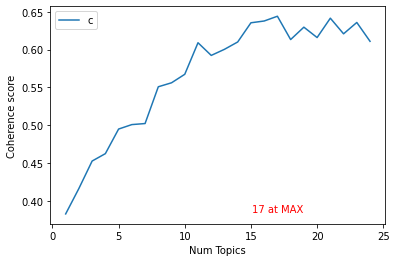

In [ ]:
limit = 25
NUM_TOPICS = find_optimal_number_of_topics(dictionary, corpus, processed_data, limit)

## LDA 모델 생성

In [ ]:
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, learning_method='online', random_state=42, max_iter=1)

In [ ]:
lda_top = lda_model.fit_transform(X)

In [ ]:
# 단어 집합. 1,000개의 단어가 저장됨.
terms = vectorizer.get_feature_names()

def get_topics(components, feature_names, n=10):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
get_topics(lda_model.components_,terms)

Topic 1: [('모유량', 215.29), ('모유중탕', 89.67), ('영양제', 62.95), ('양쪽', 49.73), ('복용', 37.51), ('모유', 32.93), ('수유패드', 30.31), ('온도', 30.03), ('수유쿠션', 16.34), ('성분', 13.99)]
Topic 2: [('질문', 482.26), ('개월', 168.79), ('유두', 141.84), ('사출', 65.22), ('멍울', 47.1), ('단유', 36.2), ('부족', 34.49), ('자연', 30.38), ('유축기브랜드명', 28.6), ('이물질', 27.23)]
Topic 3: [('수유', 537.96), ('가슴', 266.3), ('유두보호기', 62.77), ('보관', 44.37), ('소리', 35.52), ('밤중', 32.25), ('냉장', 23.53), ('계속', 21.73), ('공기', 21.4), ('시기', 19.49)]
Topic 4: [('분유', 900.93), ('외출', 78.36), ('영아산통', 56.3), ('분수토', 53.12), ('수유자세', 38.83), ('새벽', 28.99), ('필요한가요', 19.73), ('선택', 18.09), ('새벽수유', 15.74), ('가루', 15.44)]
Topic 5: [('분유명', 1114.53), ('브랜드명', 339.94), ('단계', 255.11), ('밤수', 77.96), ('분유', 65.95), ('대변양상', 59.61), ('액상', 36.61), ('분유타는법', 36.37), ('분유스푼', 35.78), ('소화', 28.19)]
Topic 6: [('모유수유', 742.43), ('음식', 414.78), ('변비', 82.74), ('계시나', 80.05), ('트림', 54.95), ('미용', 48.85), ('출산', 40.99), ('전유', 35.74), ('킨더밀쉬', 19.79), ('섭취',

In [ ]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(El

## LDA 모델 시각화

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [ ]:
pyLDAvis.save_html(vis, f"results/lda_group{GROUP}_{NUM_TOPICS}topics.html")

## LDA 값 저장

### beta 값 구하기

In [ ]:
num_words=50
beta_list = ldamodel.print_topics(num_words)

# print(beta_list)
beta_df = pd.DataFrame(index=range(0,(len(beta_list)*num_words)), columns=['topic', 'term', 'beta'])

# 'topic' 열에 값 집어넣기
for i in range(len(beta_df)):
    beta_df['topic'][i]=int(i/num_words)%num_words

idx_cnt=0
for i in range(len(beta_list)):
#     print(beta_list[i][1].split(" + "))
#     print(len(beta_list))
    for j in range(num_words):
        try:
            beta_df['term'][idx_cnt]=beta_list[i][1].split(" + ")[j].split("*")[1]
            beta_df['beta'][idx_cnt]=beta_list[i][1].split(" + ")[j].split("*")[0]
        except: # topic에 단어가 num_words만큼 있지 않은 경우
            pass
        
        idx_cnt+=1
beta_df.to_csv(f"results/lda_beta_group{GROUP}_{NUM_TOPICS}topics.csv", mode='w')

### gamma 값 구하기

In [ ]:
# 참고 :
# http://bigdata.emforce.co.kr/wp-content/uploads/%EC%97%A0%ED%8F%AC%EC%8A%A4-%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%9E%A9_%ED%86%A0%ED%94%BD%EB%AA%A8%EB%8D%B8%EB%A7%81LDA%EB%B0%A9%EB%B2%95%EB%A1%A0-%EC%A0%95%EB%A6%AC.pdf

def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()
    
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        
        for j, (topic_num, prop_topic) in enumerate(doc):
            if j==0:
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_list]), ignore_index=True)
            else:
                break
    return (topic_table)


topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index()
topictable.columns = ['문서번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중(gamma)', '각 토픽의 비중']
topictable.to_csv(f"results/lda_gamma_group{GROUP}_{NUM_TOPICS}topics.csv", mode='w')